# Anamoly Detection in New York city taxi dataset

## About the dataset
    The dataset consists of the count of taxis operating on New York City with timestamp for every 30 minutes from 2014-07 to 2015-01

## Goal

1) To check for diffrence in normal pattern. 
2) To check for Unsual datapoints.
3) To identify weather anamolies are global or of other types.
4) To visualize The anamolies
5) To find out why the anamolies occured.

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
plt.rcParams["figure.figsize"] =(10,8)

from sklearn.ensemble import IsolationForest

In [137]:
df = pd.read_csv("Nyc_taxi.csv")
df.head()

,"timestamp,value"
0,"2014-07-01 00:00:00,10844"
1,"2014-07-01 00:30:00,8127"
2,"2014-07-01 01:00:00,6210"
3,"2014-07-01 01:30:00,4656"
4,"2014-07-01 02:00:00,3820"


In [138]:
new = df["timestamp,value"].str.split(",",expand=True)

In [139]:
df["Timestamp"] = new[0]
df["Value"] = new[1]

In [140]:
df.drop(labels="timestamp,value",axis=1,inplace=True)

In [141]:
df.head()

,Timestamp,Value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [142]:
df.shape

(10320, 2)

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Timestamp  10320 non-null  object
 1   Value      10320 non-null  object
dtypes: object(2)
memory usage: 161.4+ KB


Changing the datatypes of the features

In [144]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df["Value"] = df["Value"].astype(float)

In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Timestamp  10320 non-null  datetime64[ns]
 1   Value      10320 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 161.4 KB


Changing the dataset by hour instead of half-hour for better understanding

In [146]:
df = df.set_index("Timestamp").resample("H").mean().reset_index()
df

,Timestamp,Value
0,2014-07-01 00:00:00,9485.5
1,2014-07-01 01:00:00,5433.0
2,2014-07-01 02:00:00,3346.5
3,2014-07-01 03:00:00,2216.5
4,2014-07-01 04:00:00,2189.5
...,...,...
5155,2015-01-31 19:00:00,28288.5
5156,2015-01-31 20:00:00,24138.0
5157,2015-01-31 21:00:00,24194.5
5158,2015-01-31 22:00:00,26515.0


In [147]:
fig = px.line(df.reset_index(),x="Timestamp",y="Value",title="NYC Taxi Count by Time")
fig.update_xaxes(rangeslider_visible = True)

By Visualization it is observed there are some unusual spikes in the pattern

## Feature Engineering

Creating New features from time stamp to detect the exact occurance of anamolies

In [148]:
df["Hour"] = df.Timestamp.dt.hour
df["Day"] = pd.Categorical(df.Timestamp.dt.strftime('%A'),categories =['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],ordered = True)

In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5160 entries, 0 to 5159
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Timestamp  5160 non-null   datetime64[ns]
 1   Value      5160 non-null   float64       
 2   Hour       5160 non-null   int64         
 3   Day        5160 non-null   category      
dtypes: category(1), datetime64[ns](1), float64(1), int64(1)
memory usage: 126.4 KB


<AxesSubplot:xlabel='Day'>

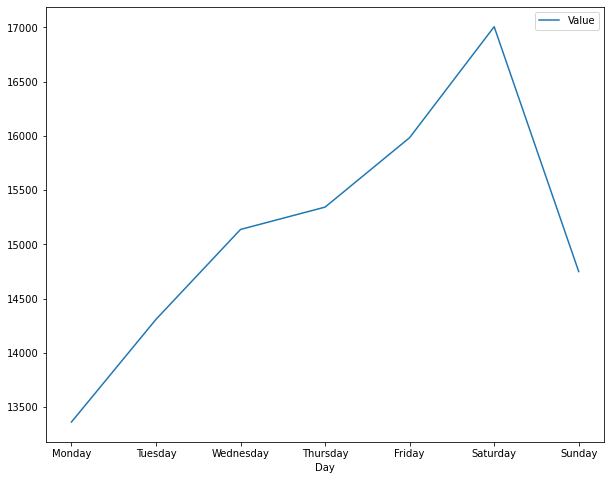

In [150]:
df[["Value","Day"]].groupby(df["Day"]).mean().plot()

The count of taxi rides decreses during the weekend 
In weekdays the taxi rides count gets higher day by day

<AxesSubplot:xlabel='Hour'>

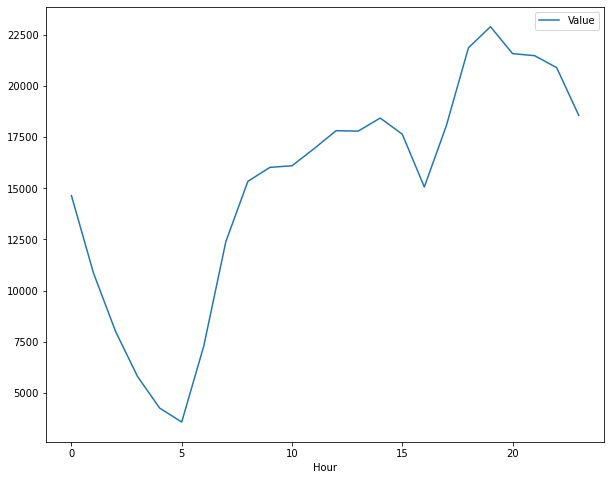

In [151]:
df[["Value","Hour"]].groupby("Hour").mean().plot()

1) From midnight till 5 am in the morning the count decreses exponentially 
2) The maximun count is observed to at 6-9 pm everyday
3) There is a slight dip of count at 3-5 pm 

<AxesSubplot:xlabel='Hour'>

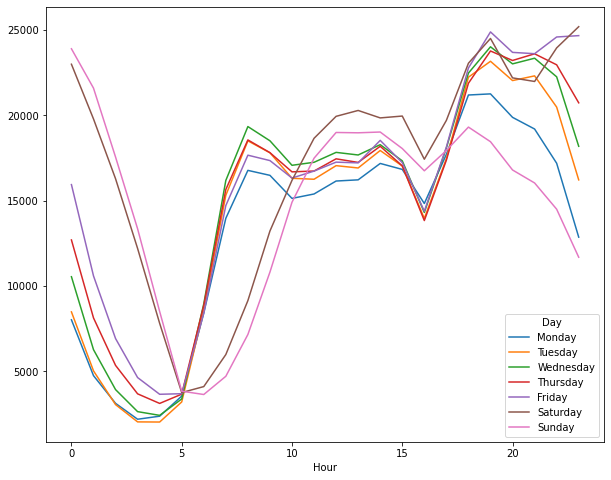

In [152]:
df.groupby(["Hour","Day"]).mean()["Value"].unstack().plot()

Weekdays follow a same pattern and weekends follow a slightly different pattern

In [153]:
df1 = df.join(df.groupby(['Hour','Day']).mean()['Value'],on=['Hour','Day'],rsuffix='_avg')
df1

,Timestamp,Value,Hour,Day,Value_avg
0,2014-07-01 00:00:00,9485.5,0,Tuesday,8483.709677
1,2014-07-01 01:00:00,5433.0,1,Tuesday,5028.193548
2,2014-07-01 02:00:00,3346.5,2,Tuesday,3052.112903
3,2014-07-01 03:00:00,2216.5,3,Tuesday,2039.580645
4,2014-07-01 04:00:00,2189.5,4,Tuesday,2031.258065
...,...,...,...,...,...
5155,2015-01-31 19:00:00,28288.5,19,Saturday,24501.870968
5156,2015-01-31 20:00:00,24138.0,20,Saturday,22193.758065
5157,2015-01-31 21:00:00,24194.5,21,Saturday,21983.241935
5158,2015-01-31 22:00:00,26515.0,22,Saturday,23949.951613


In [154]:
df1["dayn"] = df.Timestamp.dt.day

## Model building using Isolation Forest

In [155]:
data = df1[["Value","Hour","dayn"]]

In [156]:
isf = IsolationForest(max_samples=0.8)
isf.fit(data)

IsolationForest(max_samples=0.8)

In [157]:
score = isf.decision_function(data)
score

array([-0.08063254, -0.06590136, -0.06068564, ..., -0.06191751,
       -0.07401544, -0.09230689])

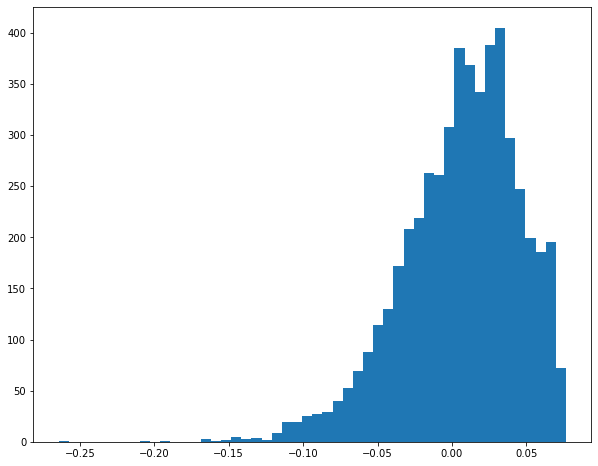

In [158]:
plt.hist(score,bins=50)
plt.show()

The lowest scored points are anamolies. A thershold can be set with domain Knowledge to further do analysis on those anamolies

In [159]:
df1["Score"] = score

Setting the threshold as -0.13


In [160]:
df1.query('Score<-0.13')

,Timestamp,Value,Hour,Day,Value_avg,dayn,Score
1511,2014-09-01 23:00:00,10366.0,23,Monday,12863.000000,1,-0.137827
1631,2014-09-06 23:00:00,29418.5,23,Saturday,25192.516129,6,-0.168646
2135,2014-09-27 23:00:00,28024.5,23,Saturday,25192.516129,27,-0.130540
2136,2014-09-28 00:00:00,26794.5,0,Sunday,23898.733333,28,-0.158408
2640,2014-10-19 00:00:00,27146.5,0,Sunday,23898.733333,19,-0.131153
2971,2014-11-01 19:00:00,27912.0,19,Saturday,24501.870968,1,-0.143803
2977,2014-11-02 01:00:00,37204.5,1,Sunday,21593.533333,2,-0.264323
3671,2014-11-30 23:00:00,9437.0,23,Sunday,11686.450000,30,-0.139471
4416,2015-01-01 00:00:00,25850.0,0,Thursday,12698.500000,1,-0.130198
4417,2015-01-01 01:00:00,29292.0,1,Thursday,8132.564516,1,-0.189393


The anamolies are matching the real world scenarios as the anamolies are detected on christmas, New Year etc.

setting contamination as 0.005

In [161]:
isf2 = IsolationForest(max_samples=0.8,contamination=0.005) # gives 0.05 % of anamolies in the dataset

In [162]:
isf2.fit(data)

C:\Users\vivek\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



IsolationForest(contamination=0.005, max_samples=0.8)

In [163]:
df1["Outlier"] = pd.Series(isf2.predict(data)).apply(lambda x: 'yes' if(x==-1) else 'no')

In [164]:
df1.query('Outlier=="yes"')

,Timestamp,Value,Hour,Day,Value_avg,dayn,Score,Outlier
1631,2014-09-06 23:00:00,29418.5,23,Saturday,25192.516129,6,-0.168646,yes
2135,2014-09-27 23:00:00,28024.5,23,Saturday,25192.516129,27,-0.130540,yes
2136,2014-09-28 00:00:00,26794.5,0,Sunday,23898.733333,28,-0.158408,yes
2640,2014-10-19 00:00:00,27146.5,0,Sunday,23898.733333,19,-0.131153,yes
2808,2014-10-26 00:00:00,26560.0,0,Sunday,23898.733333,26,-0.119863,yes
2952,2014-11-01 00:00:00,25181.0,0,Saturday,22993.064516,1,-0.119496,yes
2953,2014-11-01 01:00:00,24341.0,1,Saturday,19788.241935,1,-0.116464,yes
2971,2014-11-01 19:00:00,27912.0,19,Saturday,24501.870968,1,-0.143803,yes
2977,2014-11-02 01:00:00,37204.5,1,Sunday,21593.533333,2,-0.264323,yes
3479,2014-11-22 23:00:00,28299.0,23,Saturday,25192.516129,22,-0.120820,yes


In [165]:
fig = px.scatter(df1,x="Timestamp",y="Value",color="Outlier",hover_data=["Day","Hour","Value_avg"])
fig.update_xaxes(rangeslider_visible=True)
fig.show()

## There are some anamolies that follows normal pattern further we can do analysis on these anamoly points

There are only few global anamolies